## Семинар 6 "Segmentation"

ФИО: Усцов Артем Алексеевич

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 15 декабря 2022).  
Скорее всего будут дополнительные плюшки для призеров конкурса.


In [1]:
!pip install pytorch_lightning
!pip install imagecodecs-lite
!pip install --upgrade tifffile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 30.3 MB/s 
     |████████████████████████████████| 512 kB 76.0 MB/s 
     |████████████████████████████████| 125 kB 67.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 35.1 MB 306 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget https://www.dropbox.com/sh/z4hbbzqai0ilqht/AADp_8oefNFs2bjC2kzl2_Fqa/training.zip -P dataset/
!wget https://www.dropbox.com/sh/z4hbbzqai0ilqht/AABuUJQJ5yG5oCuziYzYu8jWa/test.zip -P dataset/

--2022-12-21 20:50:30--  https://www.dropbox.com/sh/z4hbbzqai0ilqht/AADp_8oefNFs2bjC2kzl2_Fqa/training.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/z4hbbzqai0ilqht/AADp_8oefNFs2bjC2kzl2_Fqa/training.zip [following]
--2022-12-21 20:50:31--  https://www.dropbox.com/sh/raw/z4hbbzqai0ilqht/AADp_8oefNFs2bjC2kzl2_Fqa/training.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5496d58aa5871840b15cf993f5.dl.dropboxusercontent.com/cd/0/inline/BzHbe9gZdMwAkTJuPjHLZmVrqLTUBluQF63rjgBSNESjnT87tzg53Mituc9dOg7WqQqlhpUAiJK7fUJlZ-kwLxZHONKD8xZVR1zW61GfU_cX345Fmhi7aB3ICLOmV5hgxDA6S_BCF3Pyqc5xhaVqUgOJgaTmqkAYjweOvT105Q1fSA/file# [following]
--2022-12-21 20:50:31--  https://uc5496d58aa5871840b15cf993f5.dl.dropboxusercontent.com/cd/0/inl

In [3]:
!unzip dataset/test.zip
!unzip dataset/training.zip && mv ./training ./train

Archive:  dataset/test.zip
   creating: test/
   creating: test/images/
  inflating: test/images/01_test.tif  
  inflating: test/images/02_test.tif  
  inflating: test/images/03_test.tif  
  inflating: test/images/04_test.tif  
  inflating: test/images/05_test.tif  
  inflating: test/images/06_test.tif  
  inflating: test/images/07_test.tif  
  inflating: test/images/08_test.tif  
  inflating: test/images/09_test.tif  
  inflating: test/images/10_test.tif  
  inflating: test/images/11_test.tif  
  inflating: test/images/12_test.tif  
  inflating: test/images/13_test.tif  
  inflating: test/images/14_test.tif  
  inflating: test/images/15_test.tif  
  inflating: test/images/16_test.tif  
  inflating: test/images/17_test.tif  
  inflating: test/images/18_test.tif  
  inflating: test/images/19_test.tif  
  inflating: test/images/20_test.tif  
   creating: test/mask/
 extracting: test/mask/01_test_mask.gif  
 extracting: test/mask/02_test_mask.gif  
 extracting: test/mask/03_test_mask.gif 

In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms as tsf

from pathlib import Path
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import PIL
from PIL import Image

import skimage
from skimage import io
import skimage.transform
from imagecodecs import imread
import imageio


TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
t.cuda.is_available()

True

In [6]:
!nvidia-smi

Wed Dec 21 20:50:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2] > 3:
            assert(img[:,:,3]!=255).sum() == 0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data

In [8]:
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

In [9]:
class Dataset():
    def __init__(
        self, data,
        source_transform,
        target_transform,
    ):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform

    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.datas)

In [10]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((256,256)), # increase image size
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize(
        (256,256), 
        interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),
    ]
)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [11]:
train_dataset = Dataset(train_data, s_trans, t_trans)

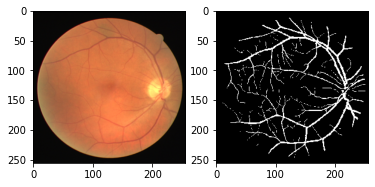

In [12]:
img, mask = train_dataset[12]

plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)

plt.subplot(122)
plt.imshow(mask[0].numpy(), cmap="gray")

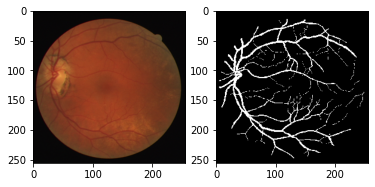

In [13]:
img, mask = train_dataset[5]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)

plt.subplot(122)
plt.imshow(mask[0].numpy(), cmap="gray")

In [14]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

# class up(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super(up, self).__init__()
#         self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
#         self.conv = double_conv(in_ch, out_ch)

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too
        # but not enough GPU memory for it with high definition images((
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [15]:
class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, n_channels, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

In [16]:
class SoftDiceLoss(nn.Module):
    '''
    soft-dice loss, useful in binary segmentation
    '''
    def __init__(self,
                 p=1,
                 smooth=1):
        super(SoftDiceLoss, self).__init__()
        self.p = p
        self.smooth = smooth

    def forward(self, probs, labels):
        '''
        inputs:
            logits: tensor of shape (N, H, W, ...)
            label: tensor of shape(N, H, W, ...)
        output:
            loss: tensor of shape(1, )
        '''
        numer = (probs * labels).sum()
        denor = (probs.pow(self.p) + labels.pow(self.p)).sum()
        loss = 1. - (2 * numer + self.smooth) / (denor + self.smooth)
        return loss


In [17]:
from torch.autograd import Variable
from IPython.display import clear_output

In [18]:
def run_net_learning_process(net, optimizer, train_loader, valid_loader,
                             epochs, criterion, scheduler,
                             plot=True, verbose=True,
                             threshold=0.5,
                            ):

    train_loss_epochs = []
    train_accuracy_epochs = []
    val_loss_epochs = []
    val_accuracy_epochs = []

    try:
        for epoch in tqdm(range(epochs)):
            # Decay Learning Rate
            scheduler.step()

            losses = []
            accuracy = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                data = data.cuda()
                target = target.cuda()
                data, target = Variable(data), Variable(target)

                optimizer.zero_grad()
                net_out = net(data)
                loss = criterion(net_out, target)
                losses.append(loss.data.item())

                accuracy = ((net_out > threshold) == target).float().mean()
                loss.backward()

                optimizer.step()

            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(accuracy.cpu())


            losses = []
            accuracy = 0
            for data, target in valid_loader:
              data = data.cuda()
              target = target.cuda()
              data, target = Variable(data), Variable(target)
              net_out = net(data)

              loss = criterion(net_out, target)
              losses.append(loss.data.item())

              accuracy = ((net_out > threshold) == target).float().mean()
            
            val_loss_epochs.append(np.mean(losses))
            val_accuracy_epochs.append(accuracy.cpu())

            # для динамического обновления графиков, wait - очищает вывод
            clear_output(wait=True) 

            # детализация выводимой информации
            if verbose:
                print(
                      f'Network: <{type(net).__name__}>\n'
                      f'Optimizer: <{type(optimizer).__name__}>\n'
                      f'Loss type: <{type(criterion).__name__}>\n\n'
                      f'Epoch: {epoch+1}\n'
                      f'<Train/Test>\n'
                      f'Loss: {np.round(train_loss_epochs[-1], 3)} / {np.round(val_loss_epochs[-1], 3)} '
                      f'| Accuracy: {train_accuracy_epochs[-1]:.3f} /{val_accuracy_epochs[-1]:.3f}'
                     )

            if plot:
                plt.figure(figsize=(12, 5))

                # Отображение изменения ошибки
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(val_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')

                # Отображение изменения accuracy
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train')
                plt.plot(val_accuracy_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()

    except KeyboardInterrupt as KI:
        print(KI)

    return train_loss_epochs, \
       train_accuracy_epochs

In [19]:
img.shape

torch.Size([3, 256, 256])

In [20]:
mask.shape

torch.Size([1, 256, 256])

In [21]:
VAL_SIZE = 2
TRAIN_SIZE = len(train_dataset) - VAL_SIZE

In [22]:
train_set, val_set = t.utils.data.random_split(train_dataset, [TRAIN_SIZE, VAL_SIZE])

train_dataloader = t.utils.data.DataLoader(train_set, batch_size=32)
val_dataloader = t.utils.data.DataLoader(val_set, batch_size=32)

In [23]:
model = UNet(3).cuda()
criterion = SoftDiceLoss().cuda()
# criterion = nn.CrossEntropyLoss().cuda()

optimizer = t.optim.RMSprop( #Adam
    model.parameters(), 
    lr=1e-4, 
    momentum=0.9, 
    weight_decay=1e-4,
)

exp_lr_scheduler = t.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)

Network: <UNet>
Optimizer: <RMSprop>
Loss type: <SoftDiceLoss>

Epoch: 200
<Train/Test>
Loss: 0.336 / 0.463 | Accuracy: 0.961 /0.932


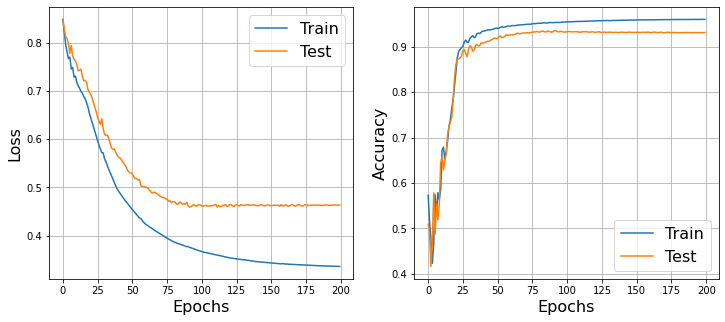

100%|██████████| 200/200 [04:21<00:00,  1.31s/it]


In [24]:
tr, tr_ac =\
run_net_learning_process(
    net=model, 
    optimizer=optimizer, 
    epochs=200, 
    criterion=criterion,
    scheduler=exp_lr_scheduler,
    train_loader=train_dataloader,
    valid_loader=val_dataloader,
    plot=True, 
    verbose=True,
    threshold=0.5,
)

По наблюдениям, 200 итераций более, чем достаточно, чтобы выйти на линию "насыщения" на трейне

In [25]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform

    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img

    def __len__(self):
        return len(self.datas)

In [26]:
testset = TestDataset(TEST_PATH, s_trans)
test_dataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [27]:
if not os.path.isdir("result"):
  os.makedirs("result")

In [28]:
model = model.eval()
for ex_id, data in enumerate(test_dataloader):
    data = t.autograd.Variable(data, volatile=True).cuda()
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)

    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)

<ipython-input-28-fe3c2956708b>:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = t.autograd.Variable(data, volatile=True).cuda()


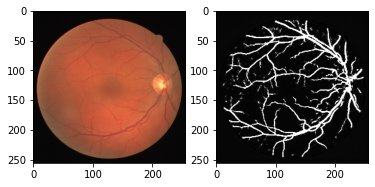

In [29]:
tm = o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm, cmap="gray")

В целом, выглядит очень реалистично

In [30]:
!zip -r result.zip result

  adding: result/ (stored 0%)
  adding: result/18.png (deflated 1%)
  adding: result/3.png (deflated 1%)
  adding: result/11.png (deflated 1%)
  adding: result/9.png (deflated 1%)
  adding: result/20.png (deflated 1%)
  adding: result/17.png (deflated 1%)
  adding: result/1.png (deflated 1%)
  adding: result/16.png (deflated 1%)
  adding: result/13.png (deflated 1%)
  adding: result/2.png (deflated 1%)
  adding: result/19.png (deflated 1%)
  adding: result/6.png (deflated 1%)
  adding: result/4.png (deflated 1%)
  adding: result/5.png (deflated 1%)
  adding: result/8.png (deflated 1%)
  adding: result/14.png (deflated 1%)
  adding: result/7.png (deflated 1%)
  adding: result/12.png (deflated 1%)
  adding: result/10.png (deflated 1%)
  adding: result/15.png (deflated 1%)


Добавим аугментации. 

Возьмем небольшие углы поворота и растяжения картинки, чтобы не сломать модель

In [83]:
jitter_param = 0.1
angle = 0.01
imsize = 256

In [84]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((imsize,imsize)),
    tsf.ColorJitter(brightness=jitter_param),
    tsf.Lambda(lambda x: tsf.functional.affine(x, angle,
                                        translate=(0, 0), scale=1, 
                                        shear = False)),
    tsf.ToTensor(),
    # tsf.RandomAffine(0.1, (0.1, 0.1)),
    # tsf.Lambda(lambda x : x + t.normal(0, 0.001, size=tuple(x.data.shape))),
    tsf.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize(
        (imsize,imsize), 
        interpolation=PIL.Image.NEAREST),
    tsf.ColorJitter(brightness=jitter_param),
    tsf.Lambda(lambda x: tsf.functional.affine(x, angle,
                                    translate=(0, 0), scale=1, 
                                    shear = False)),
    tsf.ToTensor(),
    # tsf.RandomAffine(0.1, (0.1, 0.1)),
    # tsf.Lambda(lambda x : x + t.normal(0, 0.001, size=tuple(x.data.shape))),
    ]
)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [85]:
s_trans_val = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((imsize,imsize)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
]
)
t_trans_val = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize(
        (imsize,imsize), 
        interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),
    ]
)

In [86]:
train_dataset, val_dataset = t.utils.data.random_split(train_data, [TRAIN_SIZE, VAL_SIZE])

In [87]:
train_set = Dataset(train_dataset, s_trans, t_trans)
val_set = Dataset(val_dataset, s_trans_val, t_trans_val)

In [88]:
train_dataloader = t.utils.data.DataLoader(train_set, batch_size=32)
val_dataloader = t.utils.data.DataLoader(val_set, batch_size=32)

In [90]:
model_1 = UNet(3).cuda()
criterion = SoftDiceLoss().cuda()
# criterion = nn.CrossEntropyLoss().cuda()

optimizer = t.optim.RMSprop( #Adam
    model_1.parameters(), 
    lr=1e-4, 
    momentum=0.9, 
    weight_decay=1e-4,
)

exp_lr_scheduler = t.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.6)

Network: <UNet>
Optimizer: <RMSprop>
Loss type: <SoftDiceLoss>

Epoch: 300
<Train/Test>
Loss: 0.256 / 0.308 | Accuracy: 0.946 /0.960


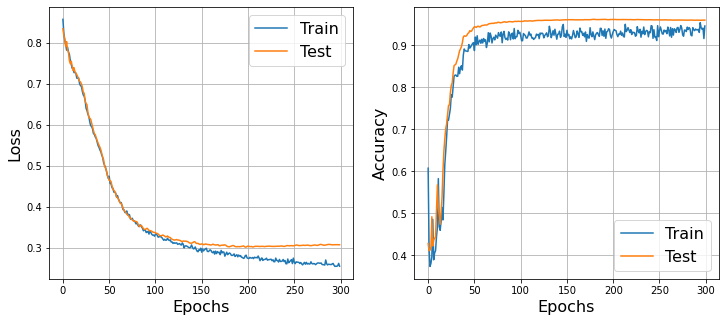

100%|██████████| 300/300 [06:32<00:00,  1.31s/it]


In [91]:
tr_aug, tr_ac_aug =\
run_net_learning_process(
    net=model_1, 
    optimizer=optimizer, 
    epochs=300, 
    criterion=criterion,
    scheduler=exp_lr_scheduler,
    train_loader=train_dataloader,
    valid_loader=val_dataloader,
    plot=True, 
    verbose=True,
    threshold=0.5,
)

In [92]:
if not os.path.isdir("result_aug"):
  os.makedirs("result_aug")

In [93]:
model_1 = model_1.eval()
for ex_id, data in enumerate(test_dataloader):
    data = t.autograd.Variable(data, volatile=True).cuda()
    o = model_1(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)

    imageio.imwrite("result_aug/%s.png" % (ex_id + 1), tm)

<ipython-input-93-3227c29e54d5>:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = t.autograd.Variable(data, volatile=True).cuda()


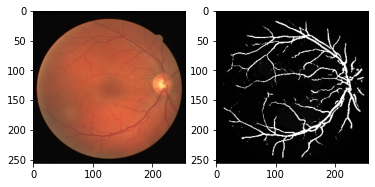

In [94]:
tm = o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm, cmap="gray")

In [95]:
!zip -r result_aug.zip result_aug

updating: result_aug/ (stored 0%)
updating: result_aug/18.png (deflated 1%)
updating: result_aug/3.png (deflated 2%)
updating: result_aug/11.png (deflated 1%)
updating: result_aug/9.png (deflated 1%)
updating: result_aug/20.png (deflated 1%)
updating: result_aug/17.png (deflated 1%)
updating: result_aug/1.png (deflated 1%)
updating: result_aug/16.png (deflated 1%)
updating: result_aug/13.png (deflated 1%)
updating: result_aug/2.png (deflated 1%)
updating: result_aug/19.png (deflated 1%)
updating: result_aug/6.png (deflated 1%)
updating: result_aug/4.png (deflated 1%)
updating: result_aug/5.png (deflated 1%)
updating: result_aug/8.png (deflated 1%)
updating: result_aug/14.png (deflated 1%)
updating: result_aug/7.png (deflated 1%)
updating: result_aug/12.png (deflated 1%)
updating: result_aug/10.png (deflated 1%)
updating: result_aug/15.png (deflated 1%)
